In [640]:
#csak akkor szabad futtatni, ha kész a debug
import warnings
warnings.filterwarnings('ignore')
#szintén
random.seed(1)

In [625]:
%matplotlib inline
import json
import sys
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import zscore
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import decomposition
from sklearn import datasets
from sklearn.decomposition import PCA
import sklearn.ensemble as ens
from sklearn.metrics import roc_curve as roc
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score as auc_score
from sklearn.metrics import accuracy_score as acc
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
import sklearn.cross_validation as xval
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split

## Adatok beolvasása

In [626]:
data = pd.read_csv("input_data/ticdata2000.txt", sep='	')

In [627]:
i=99
for c in data.columns: 
    data = data.rename(columns={c: i})
    i = i+1
for c in data.columns:
    data = data.rename(columns={c: c-98})
    i = i+1
data = data.rename(columns={86: 'CARAVAN'})

In [628]:
data.head(2)

,1,2,3,4,5,6,7,8,9,10,...,77,78,79,80,81,82,83,84,85,CARAVAN
0,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,0
1,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,0


## Változók létrehozása

In [629]:
#először is egy olyan függvényt definiálok, amely az adathalmazból leválogatja a lakókocsi biztosítással rendelkezőket úgy,
#hogy hisztogramra lehessen rakni gyorsan, tehát az indexeket sorba rendezi
def getcara(data):
    cara  = data[data['CARAVAN'] != 0]
    cara['0'] = range(0, len(cara.index))
    cara = cara.set_index('0')
    cara = cara[cara['CARAVAN'] != None]
    return cara

### 1: Hány biztosítása van?
Azt összegzi, hogy az ügyfélnek összesen hány biztosítása van. Azt feltételezem, hogy aki szeret sok mindenre biztosítást kötni, az fog lakókocsira is. Ezt bizonyítják a hisztogramok is.

In [630]:
def osszead(row):
    pol = 0
    for x in range(64,85):
        pol = pol + row[x]
    return pol
data['NumOfPolicies'] = data.apply(lambda row: osszead(row), axis = 1 )

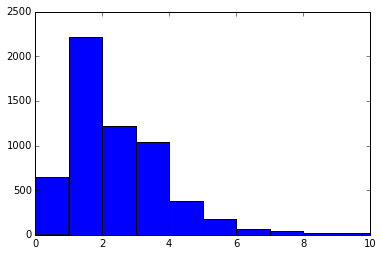

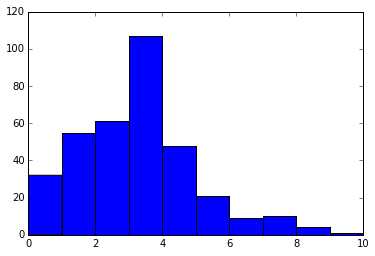

In [631]:
plt.hist(data['NumOfPolicies'], range=[0,10])
plt.show()
plt.hist(getcara(data)['NumOfPolicies'], range=[0,10])
plt.show()

### 2. MOSTYPE: Customer Subtype: kategorikus változó
Látható, hogy pl. a 8-as (Middle class families) alkategóriába tartozók gyakrabban kötnek lakókocsira biztosítást. Érdemes ebből dummy változókat létrehozni.

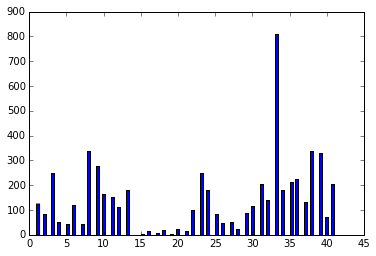

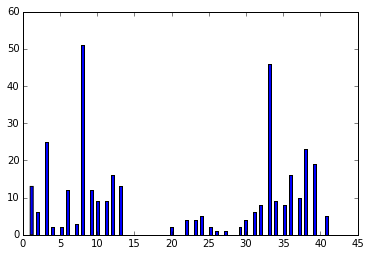

In [632]:
plt.hist(data[1], bins= 100)
plt.show()
plt.hist(getcara(data)[1], bins= 100)
plt.show()
#dummy változók létrehozása, többihez konkatenálása
d2 = pd.get_dummies(data[1])
for c in d2.columns:
    d2 = d2.rename(columns={c: "c"+str(c)})
d3 = pd.concat([data, d2], axis=1)

### 3: képzettség
Ez is befolyásolhatja a biztosítási kedvet. A változót ebből a 3 másikból rakom össze:
 - 16 MOPLHOOG High level education
 - 17 MOPLMIDD Medium level education
 - 18 MOPLLAAG Lower level education

Több oktatási pontot kap az, ahol a 16., majd 17. oszlopban szerepel magas érték.

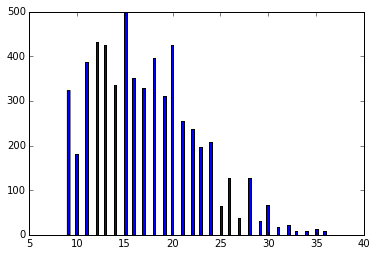

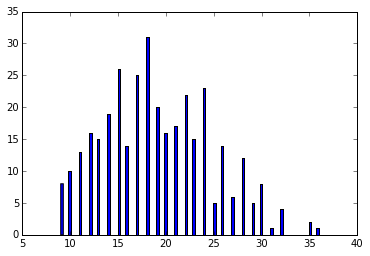

In [633]:
def edu(row):
    return row[16]*4+row[17]*2+row[18]
d3['EducationLevel'] = d3.apply(lambda row: edu(row), axis = 1 )
plt.hist(d3['EducationLevel'], bins= 100)
plt.show()
plt.hist(getcara(d3)['EducationLevel'], bins= 100)
plt.show()

### 4. bevétel:
Ez létezik, nem csinálok vele semmit, csak használom.

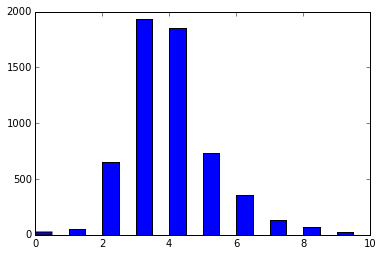

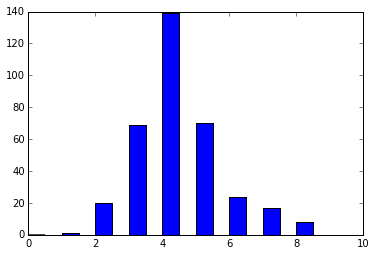

In [634]:
d3['AvgIncome'] = d3[42]
plt.hist(d3['AvgIncome'], bins = 20, range=[0,10])
plt.show()
plt.hist(getcara(d3)['AvgIncome'], bins = 20, range=[0,10])
plt.show()

### Többi változó eldobása

In [635]:
for x in range(1,86):
    d3 = d3.drop([x], axis = 1)
d3.head()

,CARAVAN,NumOfPolicies,c1,c2,c3,c4,c5,c6,c7,c8,...,c34,c35,c36,c37,c38,c39,c40,c41,EducationLevel,AvgIncome
0,0,3,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,14,5
1,0,3,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,14,3
2,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,22,4
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,28,6
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,14,3


## Tanítás

### Adat előkészítése

In [641]:
random.seed(1)
#shuffle data
sd3 = d3.iloc[np.random.permutation(len(d3))]
sd3.head(2)

,CARAVAN,NumOfPolicies,c1,c2,c3,c4,c5,c6,c7,c8,...,c34,c35,c36,c37,c38,c39,c40,c41,EducationLevel,AvgIncome
1890,1,3,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,22,6
4702,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,13,4


In [642]:
# preprocess dataset, split into training and test part
sd3_train, sd3_test = train_test_split(sd3, test_size=.25)
print(len(sd3_train))
print(len(sd3_test))

4365
1456


### Classifierek összehasonlítása

In [643]:
#!!! ezt a cellát futtatni időigényes
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree",
         "Random Forest", "AdaBoost", "Naive Bayes", "GradientBoostingClassifier"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, probability=True),
    SVC(gamma=2, C=1, probability=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    ens.GradientBoostingClassifier()]

i = 0
tbl = pd.DataFrame(columns=['name', 'score', 'xval'], index=range(0,10))

for name, clf in zip(names, classifiers):
        #print(name)
        clf.fit(sd3_train.drop('CARAVAN', axis=1), sd3_train['CARAVAN'])
        pred = clf.predict(sd3_test.drop('CARAVAN', axis=1)) #tesztelés
        prob = clf.predict_proba(sd3_test.drop('CARAVAN', axis=1))[:,1]
        #auc érték számítása
        #print('\nAUC érték:')
        auc = auc_score(sd3_test['CARAVAN'], prob)
        #print(auc)

        #roc görbe
        #print('\nROC görbe:')
        fpr, tpr, thresholds = roc(sd3_test['CARAVAN'], prob)
        #plt.plot(fpr, tpr)
        #plt.show()
        # print('\nKeresztvalidáció: a 10 pontosságérték:')
        sc = xval.cross_val_score(clf, sd3.drop('CARAVAN', axis=1), sd3['CARAVAN'], cv = 10, n_jobs=-1, scoring='roc_auc')
        #print(sc)
        
        tbl.loc[i] = [name, auc, max(sc)]
        i = i + 1         
        # print('-------------------------------------------------')
tbl = tbl.sort_values(['xval', 'score'], ascending=False)
tbl.head(8)

,name,score,xval
7,GradientBoostingClassifier,0.694775,0.802507
5,AdaBoost,0.720098,0.790128
3,Decision Tree,0.656724,0.767205
4,Random Forest,0.662758,0.766867
2,RBF SVM,0.606034,0.675555
1,Linear SVM,0.637004,0.646414
0,Nearest Neighbors,0.56376,0.590441
6,Naive Bayes,0.536698,0.543876


Több különböző paraméter, 10-es keresztvalidáció és változó méretű train-test setek mellett is a GradientBoostingClassifier bizonyult a legjobbnak.

### Összefoglalás, ROC görbe


AUC érték:
0.694775188182

ROC görbe:


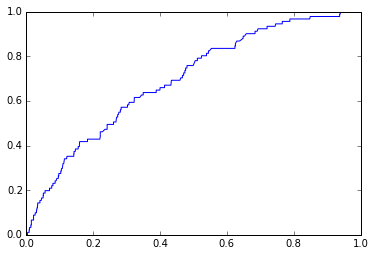

In [644]:
#modellezés
clf = ens.GradientBoostingClassifier()
#clf = SVC(gamma=0, C=15, probability=True) 
#clf = KNeighborsClassifier(5)
clf = clf.fit(sd3_train.drop('CARAVAN', axis=1), sd3_train['CARAVAN']) #tanítás
pred = clf.predict(sd3_test.drop('CARAVAN', axis=1)) #tesztelés
prob = clf.predict_proba(sd3_test.drop('CARAVAN', axis=1))[:,1]

#auc érték számítása
print('\nAUC érték:')
print(auc_score(sd3_test['CARAVAN'], prob))

#roc görbe
print('\nROC görbe:')
fpr, tpr, thresholds = roc(sd3_test['CARAVAN'], prob)
plt.plot(fpr, tpr)
plt.show()

Források:
 - Előző két házim
 - http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#
 - https://github.com/amueller/scipy_2015_sklearn_tutorial